<a href="https://colab.research.google.com/github/Singular-Brain/bindsnet/blob/master/lc_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/bindsnet

     |████████████████████████████████| 120 kB 5.3 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 280 kB 39.6 MB/s 
     |████████████████████████████████| 28.5 MB 45 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
!unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

--2021-08-21 13:59:19--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  11.0MB/s    in 1.0s    

2021-08-21 13:59:21 (11.0 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz  


In [3]:
!git clone https://github.com/Singular-Brain/bindsnet/

Cloning into 'bindsnet'...
remote: Enumerating objects: 10394, done.
remote: Counting objects: 100% (1354/1354), done.
remote: Compressing objects: 100% (743/743), done.
remote: Total 10394 (delta 952), reused 967 (delta 610), pack-reused 9040
Receiving objects: 100% (10394/10394), 60.50 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (6678/6678), done.


In [4]:
from bindsnet.network.nodes import Nodes
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from tqdm.notebook import tqdm

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import LocalConnection, Connection
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE


## Sets up Gpu use and manual seed


In [5]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Custom Monitors

## Reward Monitor

In [6]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


## Plot Eligibility trace

In [60]:
class PlotET(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        i,
        j,
        source,
        target,
        connection,
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()
        self.i = i
        self.j = j
        self.source = source
        self.target = target
        self.connection = connection

        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if hasattr(self.connection.update_rule, 'p_plus'):
            self.recording['spikes_i'].append(self.source.s.ravel()[self.i].item())
            self.recording['spikes_j'].append(self.target.s.ravel()[self.j].item())
            self.recording['p_plus'].append(self.connection.update_rule.p_plus[self.i].item())
            self.recording['p_minus'].append(self.connection.update_rule.p_minus[self.j].item())
            self.recording['eligibility'].append(self.connection.update_rule.eligibility[self.i,self.j].item())
            self.recording['eligibility_trace'].append(self.connection.update_rule.eligibility_trace[self.i,self.j].item())
            self.recording['w'].append(self.connection.w[self.i,self.j].item())

    def plot(self):

        fig, axs  = plt.subplots(7)
        fig.set_size_inches(10, 20)
        for i, (name, p) in enumerate(self.recording.items()):
            axs[i].plot(p[-250:])
            axs[i].set_title(name)
    
        fig.show()

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = {
        'spikes_i': [],
        'spikes_j': [],
        'p_plus':[],
        'p_minus':[],
        'eligibility':[],
        'eligibility_trace':[],
        'w': [],
        }


# Design network

In [59]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

class LCNet(Network):
    def __init__(
        self,
        n_classes: int,
        neuron_per_class: int,
        n_channels:int,
        filter_size: int,
        stride: int,
        online: bool,
        time: int,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_Output: float,
        nu_inh: float=0.0,
        single_output_layer:bool = False,
        NodesType_LC = LIFNodes,
        NodesType_Output = AdaptiveLIFNodes, 
        dt: float = 1.0,
        crop_size:int = 20,
        update_rule_LC = PostPre,
        update_rule_Output = MSTDPET,
        update_rule_inh = PostPre,
        wmin: float = 0.0,
        wmax: float = 1.0,
        soft_bound = False,
        theta_plus: float = 2.0,
        tc_theta_decay: float = 250,
        tc_trace:int = 20,
        inh_type = 'between_layers',
        inh_factor:float = 0.25,
        norm_factor_lc = None,
        norm_factor_out = None,
        norm_factor_inh = None,
        load_path = None,
        save_path = None,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``DiehlAndCook2015``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``DiehlAndCookNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``DiehlAndCookNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_classes
        kwargs['neuron_per_class'] = neuron_per_class
        

        self.reward_fn = reward_fn(**kwargs)
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_classes = n_classes
        self.neuron_per_class = neuron_per_class
        self.save_path = save_path
        self.load_path = load_path
        self.dt = dt
        self.time = time
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound

        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period > 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period > 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [1,20,20], traces=True, tc_trace=tc_trace)
        self.add_layer(inp, name="input")
        main = NodesType_LC(shape= [n_channels, compute_size(crop_size, filter_size, stride), 
                                        compute_size(crop_size, filter_size, stride)], 
                                        traces=True, tc_trace=tc_trace,)
                                        #adpativeLIF_parameters
                                        #tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        self.add_layer(main, name="main")
        ### connections 
        LC = LocalConnection(inp, main, filter_size, stride, n_channels, nu = _pair(nu_LC), update_rule = update_rule_LC, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_lc)
        self.add_connection(LC, "input", "main")

        ### main to output
        if single_output_layer:
            out = NodesType_Output(n= n_neurons, traces=True, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            self.add_layer(out, "output")
            main_out = Connection(main, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)
            self.add_layer(main, "main")
            self.add_connection(main_out, "main", "output")
            ### Inhibitory:
            if inh_type == 'between_layers':
                w = -inh_factor * torch.ones(out.n, out.n)
                for c in range(n_classes):
                    ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
                    w[ind, ind] = 0

                out_recurrent_inhibition = Connection(
                    source=out,
                    target=out,
                    w=w,
                    update_rule = update_rule_inh,
                    wmin=-inh_factor,
                    wmax=0,
                    nu = nu_inh,
                    norm = norm_factor_inh,
                )
                self.add_connection(out_recurrent_inhibition, "output", "output")

            # Diehl and Cook
            elif inh_type == 'DC':
                raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # else:   
        #     for c in range(n_classes):
        #         self.add_layer(
        #             NodesType_Output(n= neuron_per_class, traces=True, tc_trace=tc_trace,
        #                             #adpativeLIF_parameters
        #                             tc_theta_decay = tc_theta_decay, theta_plus = theta_plus),
        #             name=f"output_{c}",
        #         )

        #         self.add_connection(
        #             Connection(
        #                 main,
        #                 self.layers[f"output_{c}"],
        #                 update_rule = update_rule_Output,
        #                 nu = nu_inh,
        #                 wmin = wmin, 
        #                 wmax= wmax,
        #                 norm = norm_factor_inh,
        #             ),
        #             "main",
        #             f"output_{c}",
        #         )


        #     ### Inhibitory:
        #     if inh_type == 'between_layers':
        #         for source in range(n_classes):
        #             for target in range(n_classes):
        #                 if source == target:
        #                     continue
        #                 self.add_connection(
        #                     Connection(
        #                         self.layers[f"output_{source}"],
        #                         self.layers[f"output_{target}"],
        #                         update_rule = update_rule_inh,
        #                         nu = nu_inh,
        #                         wmin=-inh_factor,
        #                         wmax=0,
        #                         w= torch.ones(
        #                             self.layers[f"output_{source}"].n,
        #                             self.layers[f"output_{target}"].n,
        #                         ) * -inh_factor,
        #                         norm=norm_factor_inh,
        #                     ),
        #                     f"output_{source}",
        #                     f"output_{target}",
        #                 )
        #     elif inh_type == 'DC':
        #         inh_layer = NodesType(n= n_neurons, traces=True, tc_trace=tc_trace)
        #         self.add_layer(inh_layer, name="inh")
        #         for out_layer in range(n_classes):
        #             self.add_connection(
        #                     Connection(
        #                         self.layers[f"output_{out_layer}"],
        #                         inh_layer,
        #                         update_rule = update_rule_inh,
        #                         nu = nu_inh,
        #                         wmin = 0,
        #                         wmax=wmax,
        #                         norm = norm_factor_inh,
        #                     ),
        #                     f"output_{out_layer}",
        #                     "inh",
        #                 )
        #             self.add_connection(
        #                     Connection(
        #                         inh_layer,
        #                         self.layers[f"output_{out_layer}"],
        #                         update_rule = update_rule_inh,
        #                         nu = nu,
        #                         wmin = wmin,
        #                         wmax=0,
        #                         norm = norm_factor_inh,
        #                     ),
        #                     "inh",
        #                     f"output_{out_layer}",
        #                 ) 

        # Directs network to GPU

        if gpu:
            self.to("cuda")


    def fit(
        self,
        dataloader,
        val_loader,
        reward_hparams,
        hparams = None,
        online_validate = True,
        n_train = 2000,
        n_test = 250,
        n_val = 250,
        val_interval = 250,
        running_window_length = 250,
        verbose = True,
    ):
        manual_seed(SEED)

        # add Monitors
        main_monitor = Monitor(self.layers["main"], ["v"], time=None, device=device)
        reward_monitor = RewardMonitor(time =self.time)
        Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        tensorboard = TensorBoardMonitor(self, time = self.time)
        self.add_monitor(main_monitor, name="main")
        self.add_monitor(reward_monitor, name="reward")
        self.add_monitor(Plot_et, name="Plot_et")
        self.add_monitor(tensorboard, name="tensorboard")

        print("Begin training.\n") if verbose else None
        acc_hist = collections.deque([], running_window_length)

        #if self.single_output_layer:
        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
        # else:
        #     output_layers = set([layer for layer in self.layers if layer.startswith('output')])
        #     self.output_spikes = {}
        #     for layer in output_layers:
        #         self.output_spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=self.time)
        #         self.add_monitor(self.output_spikes[layer], name="%s_spikes" % layer)
        #         self.dopaminergic_layers = {name: layer for name, layer in self.layers.items() if name.startswith('output')}

        val_acc = 0.0

        reward_history = []
        pbar = tqdm(total=n_train)
        self.reset_state_variables()

        if self.load_path:
            # try:
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            iteration =  self.model_params['iteration']
            hparams = self.model_params['hparams']
            train_accs = self.model_params['train_accs']
            val_accs = self.model_params['val_accs']
            acc_rewards = self.model_params['acc_rewards']
        else:
            val_accs = []
            train_accs = []
            acc_rewards = []
            # except:
            #     pass
            

        for (i, datum) in enumerate(dataloader):
            if self.load_path:
                #try:
                if i <= iteration:
                    n_train += 1
                    continue
                # except:
                #     pass
            if i > n_train:
                break


            image = datum["encoded_image"]
            label = datum["label"]

            # Run the network on the input.
            if gpu:
                inputs = {"input": image.cuda().view(self.time, 1, 1, 20, 20)}
            else:
                inputs = {"input": image.view(self.time, 1, 1, 20, 20)}
            #print(self.spikes['output'].get('s'))

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    true_label = label.int().item(),
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # print(self.layers['output'].theta_plus)
            # print(self.layers['output'].theta)
            #print(self.connections[('input', 'main')].w.sum(axis=0))


            # Get voltage recording.
            main_voltage = main_monitor.get("v")
            reward_history.append(reward_monitor.get())
            tensorboard.update(step= i)
            # Add to spikes recording.
            #if self.single_output_layer:
            #print(self.monitors['output_spikes'].get('s').shape)
            lc_spikes = self.spikes['main'].get('s')
            out_spikes = self.spikes["output"].get("s").view(self.time, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(1)
            predicted_label = torch.argmax(sum_spikes)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)    

            if predicted_label == label:
                # if reward_hparams['two_pass']:
                #     reward_hparams['dopamine_for_correct_pred'] = 0.1
                #     print(' => Second pass with dopamine_for_correct_pred:', reward_hparams['dopamine_for_correct_pred'], end = '')
                #     self.run(inputs=inputs, time=self.time, **reward_hparams, labels =  label.int().item(),dopaminergic_layers= dopaminergic_layers)
                acc_hist.append(1)
            else:
                # if reward_hparams['two_pass']:
                #     reward_hparams['dopamine_for_correct_pred'] = 0.0
                #     print(' => Second pass with dopamine_for_correct_pred:', reward_hparams['dopamine_for_correct_pred'], end = '')
                #     self.run(inputs=inputs, time=self.time, **reward_hparams, labels =  label.int().item(),dopaminergic_layers= dopaminergic_layers, train=True)
                acc_hist.append(0)

            reward_hparams['dopamine_for_correct_pred'] = 0.0

            # print("\routput", sum_spikes, 'pred_label:',
            #     predicted_label.item(), 'GT:', label.item(), ' Acc Rew:',
            #     round(sum(reward_monitor.get()).item(),4),
            #     f' Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}'\
            #     , 
            #     end = '')
            print(f"input_fire_freq: {torch.mean(image.float())*1000:.1f},main_fire_freq:{torch.mean(lc_spikes.float())*1000:.1f}, output_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}" )
            acc = 100 * sum(acc_hist)/len(acc_hist)

            if online_validate and i % val_interval == 0 and i!=0:
                val_acc = self.evaluate(val_loader, n_val, val_interval, running_window_length)
                tensorboard.writer.add_scalars("accuracy", {"train": acc, "val" : val_acc}, i)
                train_accs.append(acc)
                val_accs.append(val_acc)
                acc_rewards.append(sum(reward_monitor.get()))
                if self.save_path is not None:
                    model_params = {'state_dict': self.state_dict(), 'hparams': hparams, 'iteration': i, 'val_accs': val_accs, 'train_accs': train_accs, 'acc_rewards': acc_rewards}
                    torch.save(model_params, self.save_path)
            else:
                tensorboard.writer.add_scalars("accuracy", {"train": acc}, i)
            tensorboard.writer.add_scalar("reward", sum(reward_monitor.get()), i)

            # if  i % val_interval == 0 and i!=0:
            #     fig = create_plot(self.output_spikes, reward_monitor.get(), label)
            #     tensorboard.writer.add_figure('reward', fig, i)
            
            #Plot_et.plot()    
            self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window'])
            self.reset_state_variables()  # Reset state variables.
            
            pbar.set_description_str("Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
            pbar.update()

        result_metrics = {'train_acc': acc, 'val_acc': val_acc}
        tensorboard.writer.add_hparams(
            {k:(v if type(v) in (int, float, bool, str, torch.Tensor) else str(v)) for k,v in {**train_hparams, **data_hparams, **network_hparams, **reward_hparams}.items() },
            result_metrics
        )



    def evaluate(self, val_loader, n_val, val_interval, running_window_length):
        manual_seed(SEED)
        acc_hist_val = collections.deque([], running_window_length)

        spikes_val = {}

        self.train(False)
        self.learning = False
        for (i, datum) in enumerate(val_loader):
            if i > n_val:
                break

            image = datum["encoded_image"]
            label = datum["label"]

            # Run the network on the input.
            if gpu:
                inputs = {"input": image.cuda().view(self.time, 1, 1, 20, 20)}
            else:
                inputs = {"input": image.view(self.time, 1, 1, 20, 20)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # Add to spikes recording.
            #if self.single_output_layer:
            out_spikes = self.spikes["output"].get("s").view(self.time, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(1)
            predicted_label = torch.argmax(sum_spikes)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)

            if predicted_label == label:
                acc_hist_val.append(1)
            else:
                acc_hist_val.append(0)
            
            print("\r*validation: output",sum_spikes,
                'predicted_label:', predicted_label.item(), 'GT:', label.item(),
                end = '') if verbose else None
            
            self.reset_state_variables()  # Reset state variables.

        self.train(True)
        self.learning = True
        val_acc = 100 * sum(acc_hist_val)/len(acc_hist_val)
        return val_acc

# Load Dataset

In [45]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [46]:
# Load MNIST data.
def load_datasets(network_hparams, data_hparams, mask=None, test_mask=None):
    manual_seed(SEED)
    dataset = MNIST(
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            transforms.Lambda(lambda x: x * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = dataset,
                                                    mask = mask,
                                                    ) if target_classes else None
                                            )

    # Load test dataset
    test_dataset = MNIST(   
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            transforms.Lambda(lambda x: x * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = test_dataset,
                                                    mask = mask_test,
                                                    ) if target_classes else None
                                            )
    

    return dataloader, val_loader

# Set up hyper-parameters

In [47]:
train_hparams = {
    'n_train' : 2000,
    'n_test' : 250,
    'n_val' : 250,
    'val_interval' : 250,
    'running_window_length': 250,
}

In [48]:
# Dataset Hyperparameters
target_classes = (0,1)
if target_classes:
    npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    # npz_file = np.load('bindsnet/mask_0_1.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 127.5,
    'crop_size': 20,
}

In [49]:
n_neurons = 50
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True

network_hparams = {
    'n_classes': n_classes,
    'dt' : 1,
    'single_output_layer': single_output_layer,
    'n_neurons' : n_neurons,
    'NodesType_LC': LIFNodes,
    'NodesType_Output': AdaptiveLIFNodes,
    'n_channels': 50,
    'filter_size': 12,
    'stride': 4,
    'theta_plus': 2,
    'tc_theta_decay':250,
    'inh_factor': 0.25,
    'inh_type': 'between_layers',
    'wmin': -1.,
    'wmax': 1.,
    'soft_bound': True,
    'clamping_intensity': None,
    'crop_size': 20,
    'neuron_per_class': neuron_per_class,
    'online': True,
    'tc_trace': 20,
}

# DopaminergicRPE
reward_hparams = {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    'td_nu': 0.0001,
    'tc_reward': 0,
    'dopamine_base': 0.0,
    'ema_window': 10,
    'variant' : 'pure_per_spike',
}

# Training

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
time = 750
network_hparams.update(
    {
     'time': time,
    }
)
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

In [51]:
### Spike clamping (baseline activity)
main_n_neurons = network_hparams['n_channels'] * compute_size(network_hparams['crop_size'], network_hparams['filter_size'], network_hparams['stride'])\
* compute_size(network_hparams['crop_size'], network_hparams['filter_size'], network_hparams['stride'])
clamping_intensity = None
clamp = {}
if clamping_intensity is not None:
    encoder = PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt'])
    clamp['main'] = encoder.enc(datum = torch.ones(main_n_neurons)*clamping_intensity, time=network_hparams['time'], dt=network_hparams['dt'])

Begin training.



  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

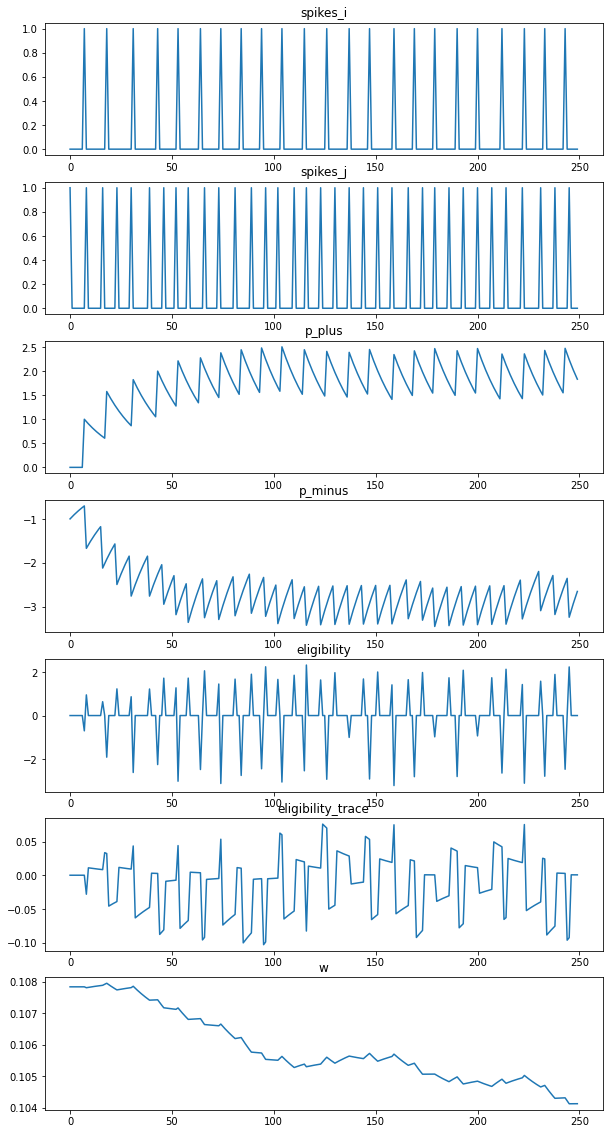

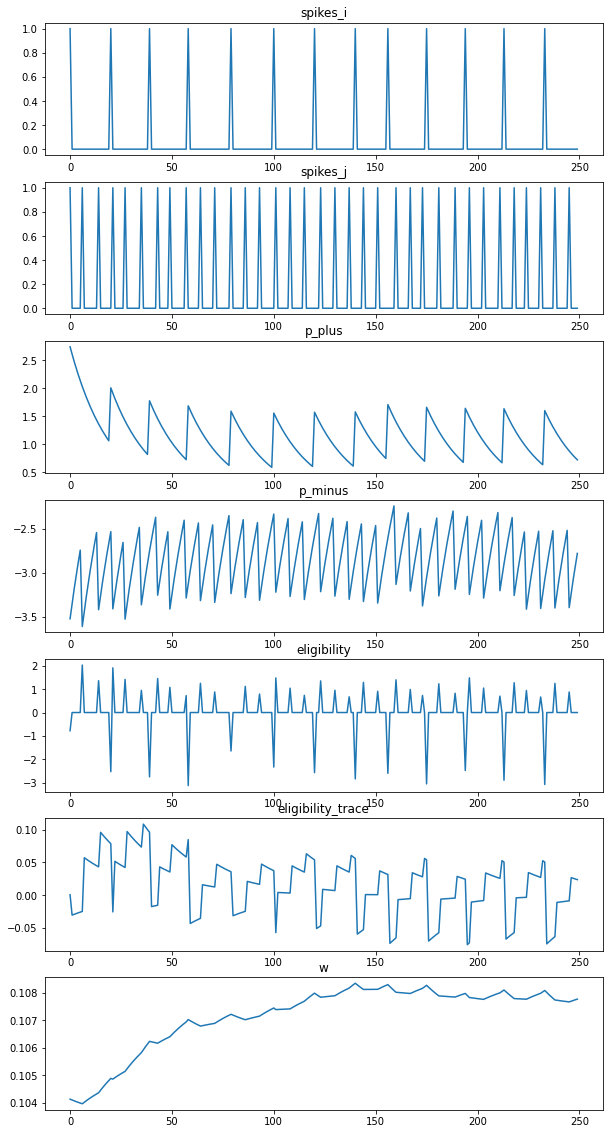

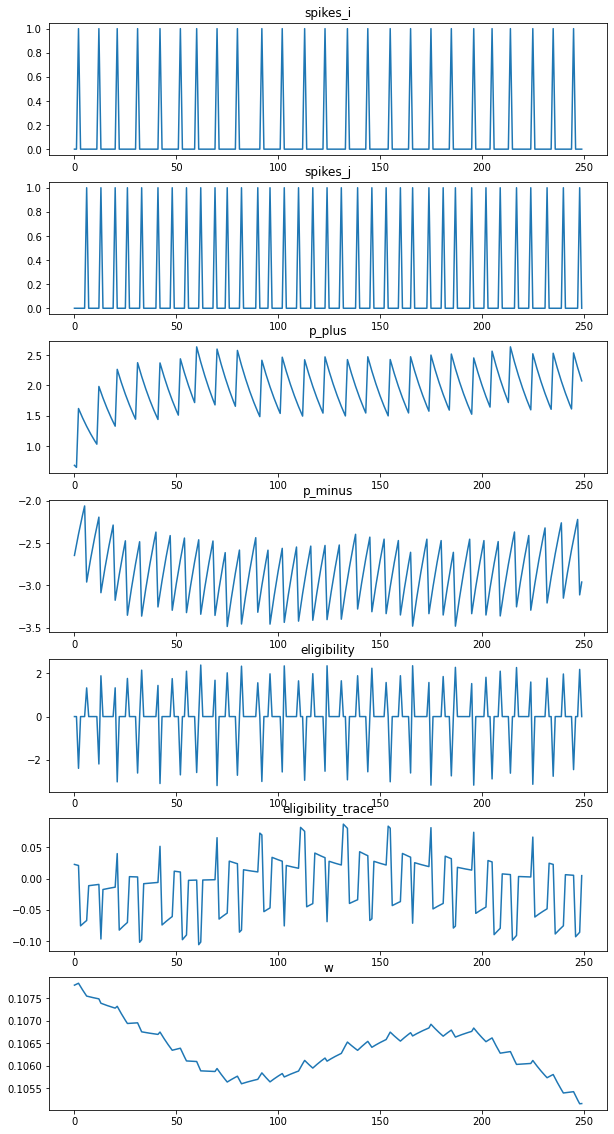

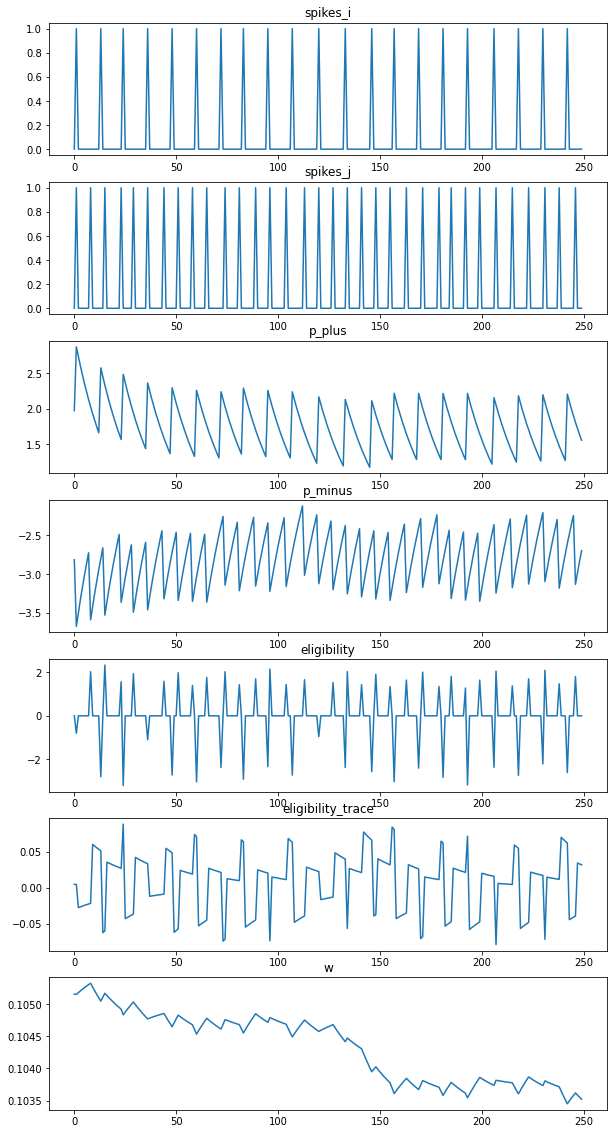

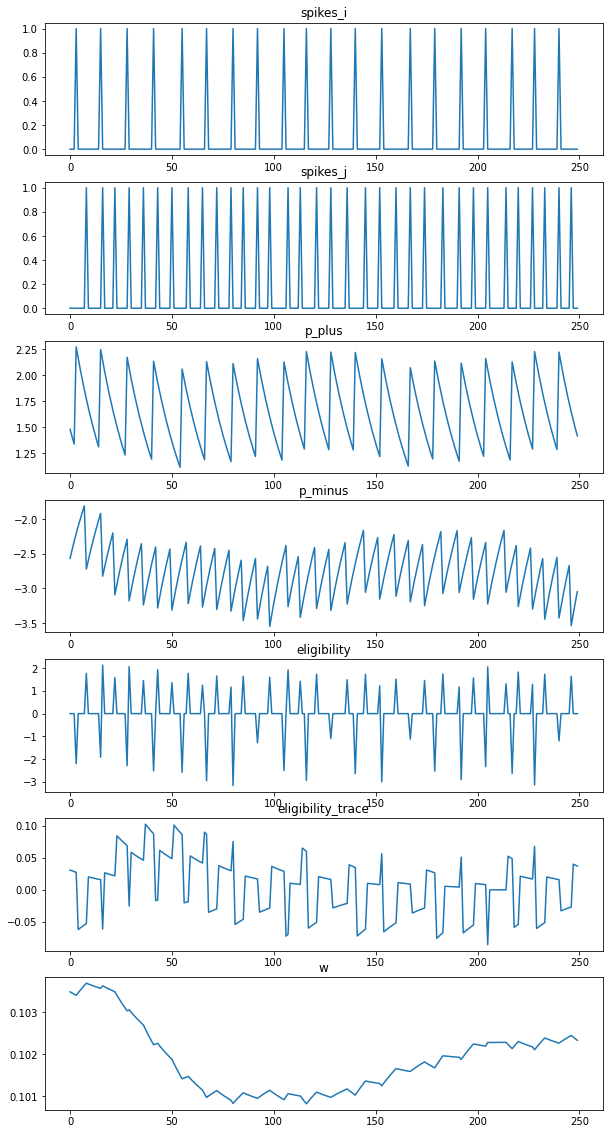

In [61]:
train_hparams.update(
    {
    'n_train' : 2000,
    'n_val' : 250,
    'val_interval' : 250,
    }
)

network_hparams.update(
    {
    'nu_LC': (0,0), #(0.0001, 0.01),
     'nu_Output': 0.0, #0.01,
    'nu_inh': 0.0,
    'theta_plus': 0.5,
     'tc_theta_decay': 250,
     'tc_trace':20,
    'time':time,
    'pre_observation': True,
    'has_decision_period': True,
    'local_rewarding': False,
     'observation_period': 250,
     'decision_period': 250,
    'inh_type': None,#'between_layers',
     'update_rule_LC': PostPre,
     'update_rule_Output': MSTDPET,
     'update_rule_inh': None,
     'online': False,
    'inh_factor': 0.25,
    'norm_factor_lc': None, # network_hparams['filter_size'] * network_hparams['filter_size'] * 0.2
    'norm_factor_out': None,# main_n_neurons * 0.2
    'norm_factor_inh': None,
    'NodesType_LC': LIFNodes,
    'NodesType_Output': AdaptiveLIFNodes, 
     'single_output_layer': True,
    'wmin': 0.0,
    'wmax': 1.0,
    'soft_bound': True,
     'clamp': clamp,
    'save_path': None,#'/content/drive/My Drive/LCNet/LCNet_var5_td_error_LIF_1_to_3_2c_gpu.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/LCNet_baseline_2c.pth',
    }
)


reward_hparams.update(
    {
    'tc_reward':0,
    'variant': 'scalar',
    'reward_base': 0.01,
    'punishment_base': 0.01,
    'dopamine_base': 0.0,
    'td_nu': 0.001,
     'tc_dps': 20,
     'dps_factor': 20,
     'sub_variant': 'static'
    }
)

manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

In [28]:
a = torch.ones(2,3)
a.double()

tensor([[1., 1., 1.],
        [1., 1., 1.]])

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
p = '/content/runs'

In [ ]:
%tensorboard --logdir $p

## Save/Load Sessions

Save tensorBoard Session 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -a /content/runs/. /content/drive/MyDrive/LCNet/logs/

Read Saved Sessions

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/LCNet/logs/

## Plotting the feature maps

In [ ]:
dataset_fmaps = MNIST(
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            transforms.Lambda(lambda x: x * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

In [ ]:
indices = dataset_fmaps.targets == 0
dataset_fmaps.data, dataset_fmaps.targets = dataset_fmaps.data[indices], dataset_fmaps.targets[indices]

idx = 20
datum = dataset_fmaps[idx]
img = datum["image"][0,:,:]
label = datum["label"]
enc_img = datum["encoded_image"].to(device)
plt.imshow(img, cmap='gray')
print('label:', label)

In [ ]:
#print(net.connections[('main', 'output_0')].w.shape)
print(net.connections[('input', 'main')].w.shape)
print(net.connections[('input', 'main')].mask.shape)
print(sum(net.connections[('input', 'main')].mask[:,0] == 0))

In [ ]:
n_filts = (int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)
n_filts

In [ ]:

fmaps = torch.zeros(network_hparams['filter_size'], network_hparams['filter_size'], network_hparams['n_channels'], int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1,\
int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)
print(fmaps.shape)
fmaps_full = torch.zeros(network_hparams['filter_size']*network_hparams['filter_size'],network_hparams['n_channels'],(int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1),\
(int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1))
print(fmaps_full.shape)

reshaped_w = net.connections[('input', 'main')].w.view(network_hparams['crop_size']*network_hparams['crop_size'],network_hparams['n_channels'],(int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1),\
    (int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1))

reshaped_msk = net.connections[('input', 'main')].mask.view(network_hparams['crop_size']*network_hparams['crop_size'],network_hparams['n_channels'],(int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1),\
    (int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1))

print(reshaped_w.shape, reshaped_msk.shape)

In [ ]:
for i in range(network_hparams['n_channels']):
    for j in range((int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)):
        for k in range((int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)):
            fmaps_full[:,i,j,k] = reshaped_w[reshaped_msk[:,i,j,k]==False, i,j,k]

In [ ]:
chan_idx = 20 # 0 to N_channels 
fig, axs = plt.subplots(n_filts, n_filts)
for i in range(n_filts):
    for j in range(n_filts):
        axs[i][j].imshow(fmaps_full[:,chan_idx,i,j].view(network_hparams['filter_size'],network_hparams['filter_size']), cmap='Greys')
        axs[i][j].axis('off')
plt.show()

## Kernel 

In [ ]:
from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

In [ ]:
class AbstractKernel(ABC):
	r"""Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
	"""
	def __init__(self, kernel_size: Union[int, Tuple[int, int]]):
    """
    Instantiates a ``Filter Kernel`` object.

    :param kernel_size: Horizontal and vertical size of convolutional kernels.
    """
		self.kernel_size = _pair(kenel_size)

	def __call__(self):
		pass


In [ ]:
class DoG_Kernel(AbstractKernel):
	r"""Generates DoG filter kernels.
	"""
	def __init__(self, 
                 kernel_size: Union[int, Tuple[int, int]], 
                 sigma1 : float,
                 sigma2 : float):
        """
		:param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
		:param sigma1 : The sigma parameter for the first Gaussian function.
		:param sigma2 : The sigma parameter for the second Gaussian function.
		"""
        super(DoG_Kernel, self).__init__(kernel_size)
		self.sigma1 = sigma1
		self.sigma2 = sigma2

	# returns a 2d tensor corresponding to the requested DoG filter
	def __call__(self):
		k = self.kernel_size//2
		x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
		a = 1.0 / (2 * math.pi)
		prod = x*x + y*y
		f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
		f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
		dog = a * (f1-f2)
		dog_mean = np.mean(dog)
		dog = dog - dog_mean
		dog_max = np.max(dog)
		dog = dog / dog_max
		dog_tensor = torch.from_numpy(dog)
		return dog_tensor.float()

## Izhikevich 2007 - Task 2

In [ ]:
if target_classes:
    # npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    npz_file = np.load('bindsnet/mask_0.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
else:
    mask = None
    mask_test = None
    n_classes = 10

network_hparams.update(
    {
     'time': 250,
    }
)

dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

train_hparams.update(
    {
    'n_train' : 2000,
    'n_val' : 250,
    'val_interval' : 250,
    }
)

network_hparams.update(
    {
    'nu': 0.1,
    'theta_plus': 0.5,
     'tc_theta_decay': 250,
     'tc_trace':20,
    'pre_observation': False,
    'has_decision_period': False,
    'local_rewarding': False,
     'observation_period': 250,
     'decision_period': 250,
     'update_rule_LC': MSTDPET,
     'update_rule_Output': MSTDPET,
     'online': True,
    'NodesType_LC': LIFNodes,
    'NodesType_Output': AdaptiveLIFNodes, 
     'single_output_layer': True,
    'save_path': None,#'/content/drive/My Drive/LCNet/LCNet_var5_td_error_LIF_1_to_3_2c_gpu.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/LCNet_baseline_2c.pth',
    }
)


reward_hparams.update(
    {
    'tc_reward':0,
    'variant': 'pure_per_spike',
    'reward_base': 0.1,
    'punishment_base': 0.1,
    'dopamine_base': 0.0,
     'tc_dps': 0,
     'dps_factor': 50,
     'sub_variant': 'static'
    }
)

manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

Begin training.



  0%|          | 0/2000 [00:00<?, ?it/s]

output tensor([1323,   66]) pred_label: 0 GT: 0  Acc Rew: 125.7  Pos dps: 0.10000, Neg dps: 0.10000, Rew base: 0.10000, Pun base: 0.10000, RPe: 121.493

KeyboardInterrupt: ignored

In [ ]:
if target_classes:
    # npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    npz_file = np.load('bindsnet/mask_1.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
else:
    mask = None
    mask_test = None
    n_classes = 10
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, hparams = hparams, **train_hparams)

Begin training.



  0%|          | 0/2000 [00:00<?, ?it/s]

output tensor([ 8, 29]) pred_label: 1 GT: 1  Acc Rew: 2.1  Pos dps: 0.10000, Neg dps: 0.10000, Rew base: 0.10000, Pun base: 0.10000, RPe: 0.505

KeyError: ignored

#Optuna

install and import optuna

In [ ]:
!pip install optuna
import optuna

Define objective function

In [ ]:
STUDY_NAME  = ''
DATA_PATH = ''
N_TRIALS = ''

def objective(trial):
    ### Suggest parameters: 
    num_layers = trial.suggest_int('Number of Layers', 1, 4)
    dropout_rate  = trial.suggest_float('Dropout', 0, .99)
    activation = trial.suggest_categorical('activation', ['relu', 'selu', 'sigmoid', 'elu'])
    lr = trial.suggest_float('Learning rate', 1e-6, 1)
    network_hparams.update({
        
    })
    ###Define your model
    manual_seed(SEED)
    hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
    net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
    va_acc = net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)
    ### Define objective value
    objective_value = min(va_acc)

    
    return objective_value


Run the study

In [ ]:
study = optuna.create_study(study_name = STUDY_NAME , storage=f"sqlite:////content/drive/MyDrive/LCNet/optuna/optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=N_TRIALS )

In [ ]:
study.best_params

{'Dropout': 0.09142336347778651,
 'Layer 1': 82,
 'Layer 2': 508,
 'Layer 3': 286,
 'Learning rate': 0.008771184760927113,
 'Number of Layers': 3,
 'activation': 'relu',
 'l1': None}

Visualization

In [ ]:
plot_parallel_coordinate(study, params=["Learning rate", "Number of Layers", "Dropout"])